In [13]:
import pandas as pd
import seaborn as sb
import numpy as np
import warnings
import importlib
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from xgboost import XGBClassifier, DMatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


## Loading

In [2]:
train_df = pd.read_csv(r"Data\train.csv")
test_df = pd.read_csv(r"Data\test.csv")
sub_df = pd.read_csv(r"Data\sample_submission.csv")

## Explore Data

In [3]:
train_df.describe()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
count,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05
mean,99999.500000,6.421457e-07,-0.000003,-0.000014,-0.000010,0.000005,0.000025,0.000014,-0.000009,-0.000028,...,0.000135,0.000348,0.000253,0.000464,0.000581,0.000379,0.000062,8.982134e-05,1.170014e-04,2.215407e-07
std,57735.171256,8.654927e-05,0.000132,0.000287,0.000436,0.000683,0.000869,0.000775,0.000441,0.000107,...,0.000711,0.001117,0.000914,0.001238,0.001528,0.001182,0.000466,5.475606e-04,6.788277e-04,2.050081e-05
min,0.000000,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
25%,49999.750000,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
50%,99999.500000,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000237,-0.000199,-0.000114,-0.000043,...,0.000014,0.000064,0.000047,0.000124,0.000114,0.000043,-0.000010,4.632568e-07,4.632568e-07,-9.536743e-07
75%,149999.250000,-9.536743e-07,-0.000003,-0.000013,-0.000004,-0.000011,0.000003,-0.000030,0.000004,-0.000028,...,0.000111,0.000463,0.000297,0.000684,0.000774,0.000365,0.000030,6.046326e-05,6.946326e-05,-9.536743e-07
max,199999.000000,9.999046e-03,0.009990,0.009957,0.009886,0.019800,0.019760,0.019800,0.009886,0.009957,...,0.019957,0.019914,0.019957,0.019914,0.019914,0.019957,0.009990,9.990463e-03,1.999046e-02,9.990463e-04


In [4]:
#Missing values
miss_val_train = train_df.isna().any().sum()
miss_val_test = test_df.isna().any().sum()
print("Train set missing values: ", miss_val_test)
print("Test set missing values: ", miss_val_test)
#Duplicate values
dup_val_train = train_df.duplicated().sum()
dup_val_test = test_df.duplicated().sum()
print("Train set duplicate values: ", dup_val_train)
print("Test set duplicate values: ", dup_val_test)
#Drop duplicate values
train_df.drop_duplicates(keep='first', inplace=True)
test_df.drop_duplicates(keep='first', inplace=True)
print("Duplicates after dropping: ", train_df.duplicated().sum()+test_df.duplicated().sum())

Train set missing values:  0
Test set missing values:  0
Train set duplicate values:  0
Test set duplicate values:  0
Duplicates after dropping:  0


In [5]:
ele = [c for c in train_df if c != 'row_id' and c!='target']
train_df.drop_duplicates(subset=ele, keep='first',inplace = True)
le = LabelEncoder()
train_df['target_n'] = le.fit_transform(train_df.target)

In [ ]:
X = train_df.iloc[:,1:-2]
y = train_df['target_n']
d_train = DMatrix(data=X, label=y)
test = test_df.drop(labels='row_id', axis=1)

## Model & Pipeline

In [ ]:
N_Splits=10

scores = []
y_probs = []
folds = StratifiedKFold(n_splits=N_Splits, shuffle=True)
for fold, (train_id, test_id) in enumerate(folds.split(X, y)):  
    X_train = X.iloc[train_id]
    y_train = y.iloc[train_id]
    X_valid = X.iloc[test_id]
    y_valid = y.iloc[test_id]

    model_xgb = XGBClassifier(verbosity=0, silent=True)
    model_xgb.fit(X_train, y_train)

    valid_pred = model_xgb.predict(X_valid)
    valid_score = accuracy_score(y_valid, valid_pred)

    print("Fold: ", fold + 1, "Accuracy: ", valid_score)
    scores.append(valid_score)
    y_probs.append(model_xgb.predict_proba(test))

In [14]:
print("Mean accuracy score:", np.array(scores).mean())

Mean accuracy score: 0.9709741348808049


## Evaluating Model on the Test Set

In [19]:
xgb_preds = model_xgb.predict(test)

C:\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:ylabel='Count'>

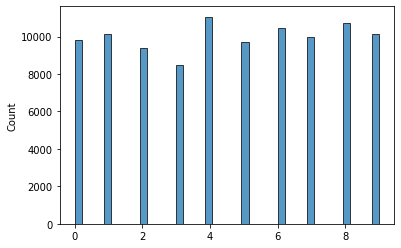

In [20]:
sb.histplot(xgb_preds)

In [22]:
sub_df["target"] = le.inverse_transform(xgb_preds)
sub_df.to_csv("submission.csv", index=False)